In [1]:
import numpy as np
np.random.seed(42)

def generate_dataset(num_sequences=2**8):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 12)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


In [2]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    all_words = flatten(sequences)
    
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    
    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Consistency error: something went wrong in the conversion.'

We have 256 sentences and 4 unique tokens in our dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


In [3]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')


We have 204 samples in the training set.
We have 25 samples in the validation set.
We have 25 samples in the test set.


In [4]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' has shape (2, 4, 1).


## RNN Implementation

In [5]:
hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    This is a common initiailization for recurrent neural networks.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param


def init_rnn(hidden_size, vocab_size):
    """
    Initializes our recurrent neural network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
    """
    # Weight matrix (input to hidden state)
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    b_out = np.zeros((vocab_size, 1))
    
    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)
    
    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)
print('U:', params[0].shape)
print('V:', params[1].shape)
print('W:', params[2].shape)
print('b_hidden:', params[3].shape)
print('b_out:', params[4].shape)

for param in params:
    assert param.ndim == 2, \
        'all parameters should be 2-dimensional '\
        '(hint: a dimension can simply have size 1)'

U: (50, 4)
V: (50, 50)
W: (4, 50)
b_hidden: (50, 1)
b_out: (4, 1)


#### Implementing Basic Functions

In [6]:
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

In [7]:
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

In [8]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f

#### Forward Pass

In [9]:
def forward_pass(inputs, hidden_state, params):
    """
    Computes the forward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `hidden_state`: an already initialized hidden state
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []
    
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        hidden_state_prev = hidden_states[t-1] if t > 0 else hidden_state
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state_prev) + b_hidden)

        # Compute output
        out = softmax(np.dot(W, hidden_state) + b_out)
        
        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())
    
    return outputs, hidden_states


# Get first sequence in training set
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'b', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'a', 'a', 'a', 'b', 'b', 'a', 'b']


In [10]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

In [11]:
def backward_pass(inputs, outputs, hidden_states, targets, params):
    """
    Computes the backward pass of a vanilla RNN.
    
    Args:
     `inputs`: sequence of inputs to be processed
     `outputs`: sequence of outputs from the forward pass
     `hidden_states`: sequence of hidden_states from the forward pass
     `targets`: sequence of targets
     `params`: the parameters of the RNN
    """
    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params
    
    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)
    
    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0
    
    # For each element in output sequence
    # NB: We iterate backwards s.t. t = N, N-1, ... 1, 0
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        loss += -1*np.log(outputs[t][np.argmax(targets[t])][0])
        
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1
        
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o
        
        d_h = np.dot(W.T, d_o) + d_h_next
        
        d_f = (1 - hidden_states[t]**2) * d_h
        d_b_hidden += d_f
        
        d_U += np.dot(d_f, inputs[t].T)
        
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    
    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out    
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads
        


loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print('We get a loss of:')
print(loss)


We get a loss of:
19.442576294993177


In [12]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

#### Training Loop

Epoch 0, training loss: 15.910508980828963, validation loss: 16.77082373423666
Epoch 100, training loss: 5.842587609551899, validation loss: 5.961775262985713
Epoch 200, training loss: 4.837018727735779, validation loss: 5.1858526349135605
Epoch 300, training loss: 4.597945355563288, validation loss: 5.042666304439337
Epoch 400, training loss: 4.614525975998632, validation loss: 5.358800478112993
Epoch 500, training loss: 4.688253280743628, validation loss: 5.525259372086577
Epoch 600, training loss: 4.623338573450351, validation loss: 5.280416544872708
Epoch 700, training loss: 4.432645988520303, validation loss: 5.06703114140339
Epoch 800, training loss: 4.316693612553475, validation loss: 4.9507236393319065
Epoch 900, training loss: 4.216705015299984, validation loss: 4.816942413797928
Input sentence:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['b', 'a', 'a', 'a', 'b', 'b', 'b', 'EOS']


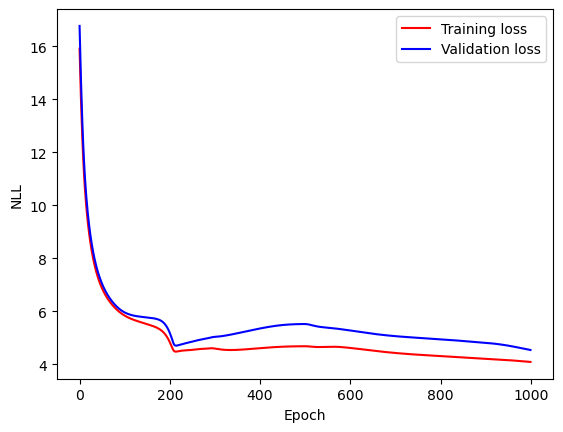

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 1000

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
     # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)
        
        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)
        
        if np.isnan(loss):
            raise ValueError('Gradients have vanished/exploded!')
        
        # Update parameters
        params = update_parameters(params, grads)
        
        # Update loss
        epoch_training_loss += loss
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

#### Extrapolation

In [15]:
def freestyle(params, sentence='', num_generate=10):
    """
    Takes in a sentence as a string and outputs a sequence
    based on the predictions of the RNN.
    
    Args:
     `params`: the parameters of the network
     `sentence`: string with whitespace-separated tokens
     `num_generate`: the number of tokens to generate
    """
    sentence = sentence.split(' ')
    
    sentence_one_hot = one_hot_encode_sequence(sentence, vocab_size)
    
    # Initialize hidden state as zeros
    hidden_state = np.zeros((hidden_size, 1))

    # Generate hidden state for sentence
    outputs, hidden_states = forward_pass(sentence_one_hot, hidden_state, params)
    
    # Output sentence
    output_sentence = sentence
    
    # Append first prediction
    word = idx_to_word[np.argmax(outputs[-1])]    
    output_sentence.append(word)
    
    # Forward pass
    for i in range(num_generate):

        # Get the latest prediction and latest hidden state
        output = outputs[-1]
        hidden_state = hidden_states[-1]
    
        # Reshape our output to match the input shape of our forward pass
        output = output.reshape(1, output.shape[0], output.shape[1])
    
        # Forward pass
        outputs, hidden_states = forward_pass(output, hidden_state, params)
        
        # Compute the index of the most likely word and look up the corresponding word
        word = idx_to_word[np.argmax(outputs)]
        
        output_sentence.append(word)
        
        if word == 'EOS':
            break
        
    return output_sentence


# Perform freestyle (extrapolation)
test_examples = ['a a b', 'a a a a b', 'a a a a a a b', 'a', 'r n n']
for i, test_example in enumerate(test_examples):
    print(f'Example {i}:', test_example)
    print('Predicted sequence:', freestyle(params, sentence=test_example), end='\n\n')

Example 0: a a b
Predicted sequence: ['a', 'a', 'b', 'b', 'EOS']

Example 1: a a a a b
Predicted sequence: ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'a']

Example 2: a a a a a a b
Predicted sequence: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Example 3: a
Predicted sequence: ['a', 'b', 'EOS']

Example 4: r n n
Predicted sequence: ['r', 'n', 'n', 'EOS', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']



## LSTMs

A vanilla RNN suffers from vanishing gradient problem. So, the researchers turned their attention to LSTMs. There are three types of gates in LSTMs:

<ul>
    <li> Forget Gate: This gate decides which information needs attention and which can be ignored. </li>
    <li> Input Gate </li>
    <li> Output Gate </li>
</ul>

<img src="LSTM.png" />
<img src="LSTM2.png" />

#### Initialization of LSTM

In [16]:
# Size of concatenated hidden + input vector
z_size = hidden_size + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Initializes our LSTM network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # Weight matrix (forget gate)
    W_f = np.zeros((hidden_size, z_size))
    
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))

    # Weight matrix (input gate)
    W_i = np.zeros((hidden_size, z_size))
    
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))

    # Weight matrix (candidate)
    W_g = np.zeros((hidden_size, z_size))
    
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))

    # Weight matrix of the output gate
    W_o = np.zeros((hidden_size, z_size))
    
    # Bias for output gate
    b_o = np.zeros((hidden_size, 1))

    # Weight matrix relating the hidden-state to the output
    W_v = np.zeros((vocab_size, hidden_size))
    
    # Bias for logits
    b_v = np.zeros((vocab_size, 1))
    
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)
print('W_f:', params[0].shape)
print('W_i:', params[1].shape)
print('W_g:', params[2].shape)
print('W_o:', params[3].shape)
print('W_v:', params[4].shape)
print('b_i:', params[5].shape)
print('b_g:', params[6].shape)
print('b_o:', params[7].shape)
print('b_v:', params[8].shape)

for param in params:
    assert param.ndim == 2, \
        'all parameters should be 2-dimensional '\
        '(hint: a dimension can simply have size 1)'

W_f: (50, 54)
W_i: (50, 54)
W_g: (50, 54)
W_o: (50, 54)
W_v: (4, 50)
b_i: (50, 1)
b_g: (50, 1)
b_o: (50, 1)
b_v: (50, 1)


In [17]:
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Append the initial cell and hidden state to their respective lists
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:
        
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)
        
        # Calculate forget gate
        f = softmax(np.dot(W_f, z) + b_f)
        f_s.append(f)
        
        # Calculate input gate
        i = softmax(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # Calculate memory state
        C_prev = np.multiply(C_prev, f) + np.multiply(g, i)
        C_s.append(C_prev)
        
        # Calculate output gate
        o = softmax(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculate softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sentence:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'UNK', 'UNK', 'UNK', 'EOS', 'EOS', 'EOS', 'EOS']


#### Backward Pass

In [18]:
def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


# Perform a backward pass
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print('We get a loss of:')
print(loss)

We get a loss of:
2.7726512690013894


Epoch 0, training loss: 3.0793761865819556, validation loss: 4.29753830569197
Epoch 10, training loss: 2.7590127032750336, validation loss: 2.8396692737708324
Epoch 20, training loss: 1.4964384222305356, validation loss: 1.5586792178431634
Epoch 30, training loss: 1.4024146066238103, validation loss: 1.429837543713019
Epoch 40, training loss: 1.3922469528528612, validation loss: 1.4164724942657714
Epoch 50, training loss: 1.387741757211103, validation loss: 1.4106886526588158
Epoch 60, training loss: 1.3661140908473919, validation loss: 1.3924045916729344
Epoch 70, training loss: 1.342458821601404, validation loss: 1.3735861169923682
Epoch 80, training loss: 1.3401960609749899, validation loss: 1.3767730609207791
Epoch 90, training loss: 1.3387989344700892, validation loss: 1.375256569199398
Epoch 100, training loss: 1.337498918903253, validation loss: 1.3738925937007729
Epoch 110, training loss: 1.3366153389516675, validation loss: 1.3733529502333008
Epoch 120, training loss: 1.336094

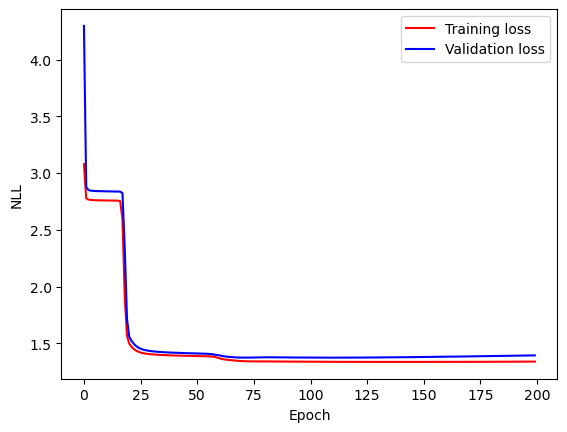

In [20]:
# Hyper-parameters
num_epochs = 200

# Initialize a new network
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update parameters
        params = update_parameters(params, grads, lr=1e-1)
        
        # Update loss
        epoch_training_loss += loss
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

    
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

# Print example
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## PyTorch Implementation of LSTM

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=vocab_size,
                         hidden_size=50,
                         num_layers=1,
                         bidirectional=False)
        
        # Output layer
        self.l_out = nn.Linear(in_features=50,
                            out_features=vocab_size,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = MyRecurrentNet()
print(net)

MyRecurrentNet(
  (lstm): LSTM(4, 50)
  (l_out): Linear(in_features=50, out_features=4, bias=False)
)
